In [ ]:
# STEP 1: Install required packages & Import libraries
!pip install tensorflow tqdm --quiet
import tensorflow as tf
from PIL import Image, ImageDraw
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19 # Using VGG19 for transfer learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns # For heatmap visualization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
print("TensorFlow Version:", tf.__version__)


TensorFlow Version: 2.18.0


In [ ]:
# Unzipping and loading the dataset
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='CT-scan.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('CT-scan.zip')
f.keys()
!unzip 'CT-scan.zip'

Archive:  CT-scan.zip
  inflating: Data/test/adenocarcinoma/000108 (3).png  
  inflating: Data/test/adenocarcinoma/000109 (2).png  
  inflating: Data/test/adenocarcinoma/000109 (4).png  
  inflating: Data/test/adenocarcinoma/000109 (5).png  
  inflating: Data/test/adenocarcinoma/000112 (2).png  
  inflating: Data/test/adenocarcinoma/000113 (7).png  
  inflating: Data/test/adenocarcinoma/000114 (5).png  
  inflating: Data/test/adenocarcinoma/000114.png  
  inflating: Data/test/adenocarcinoma/000115 (4).png  
  inflating: Data/test/adenocarcinoma/000115 (8).png  
  inflating: Data/test/adenocarcinoma/000115.png  
  inflating: Data/test/adenocarcinoma/000116 (5).png  
  inflating: Data/test/adenocarcinoma/000116 (7).png  
  inflating: Data/test/adenocarcinoma/000116 (9).png  
  inflating: Data/test/adenocarcinoma/000117 (4).png  
  inflating: Data/test/adenocarcinoma/000117 (8).png  
  inflating: Data/test/adenocarcinoma/000117.png  
  inflating: Data/test/adenocarcinoma/000118 (5).png  


In [ ]:
# STEP 3: Define paths
input_root = '/content/Data/train'     # The image dataset path
output_root = '/content/CT-scan'    # The Output folder for segmentation masks
os.makedirs(output_root, exist_ok=True)

# STEP 4: Preprocessing function
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB').resize((128, 128))
    image_array = np.array(image) / 255.0
    return np.expand_dims(image_array, axis=0), image.size

# STEP 5: Dummy segmentation model (replace this with real model later)
def dummy_segmentation_model(image_tensor):
    # Simple green channel threshold for demo purposes
    mask = (image_tensor[0][:, :, 1] > 0.5).astype(np.uint8) * 255
    return mask

# STEP 6: Iterate over all class folders
for class_name in os.listdir(input_root):
    class_input_path = os.path.join(input_root, class_name)

    # Skip non-directories like .DS_Store
    if not os.path.isdir(class_input_path):
        continue

    class_output_path = os.path.join(output_root, class_name)
    os.makedirs(class_output_path, exist_ok=True)

    # STEP 7: Process each image
    for img_name in tqdm(os.listdir(class_input_path), desc=f"Processing {class_name}"):
        img_path = os.path.join(class_input_path, img_name)

        # Skip non-image files
        if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        try:
            img_tensor, original_size = preprocess_image(img_path)

            # Dummy segmentation
            mask = dummy_segmentation_model(img_tensor)

            # Resize mask back to original image size and save
            mask_image = Image.fromarray(mask).resize(original_size)
            mask_image.save(os.path.join(class_output_path, img_name))

        except Exception as e:
            print(f"❌ Failed to process {img_path}: {e}")


Processing adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib: 100%|██████████| 195/195 [00:01<00:00, 181.24it/s]
Processing normal: 100%|██████████| 148/148 [00:01<00:00, 88.83it/s]
Processing squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa: 100%|██████████| 155/155 [00:00<00:00, 181.84it/s]
Processing large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa: 100%|██████████| 115/115 [00:00<00:00, 190.23it/s]


In [ ]:
IMAGE_SIZE = 224 # All CT scan images will be uniformly resized to 224x224 pixels.
BATCH_SIZE = 32  # Images will be processed in batches of 32.
CHANNELS = 3     # Images will be loaded as 3-channel (RGB) images.
EPOCHS = 10      # Defines the maximum number of times the model will iterate over the entire training dataset.


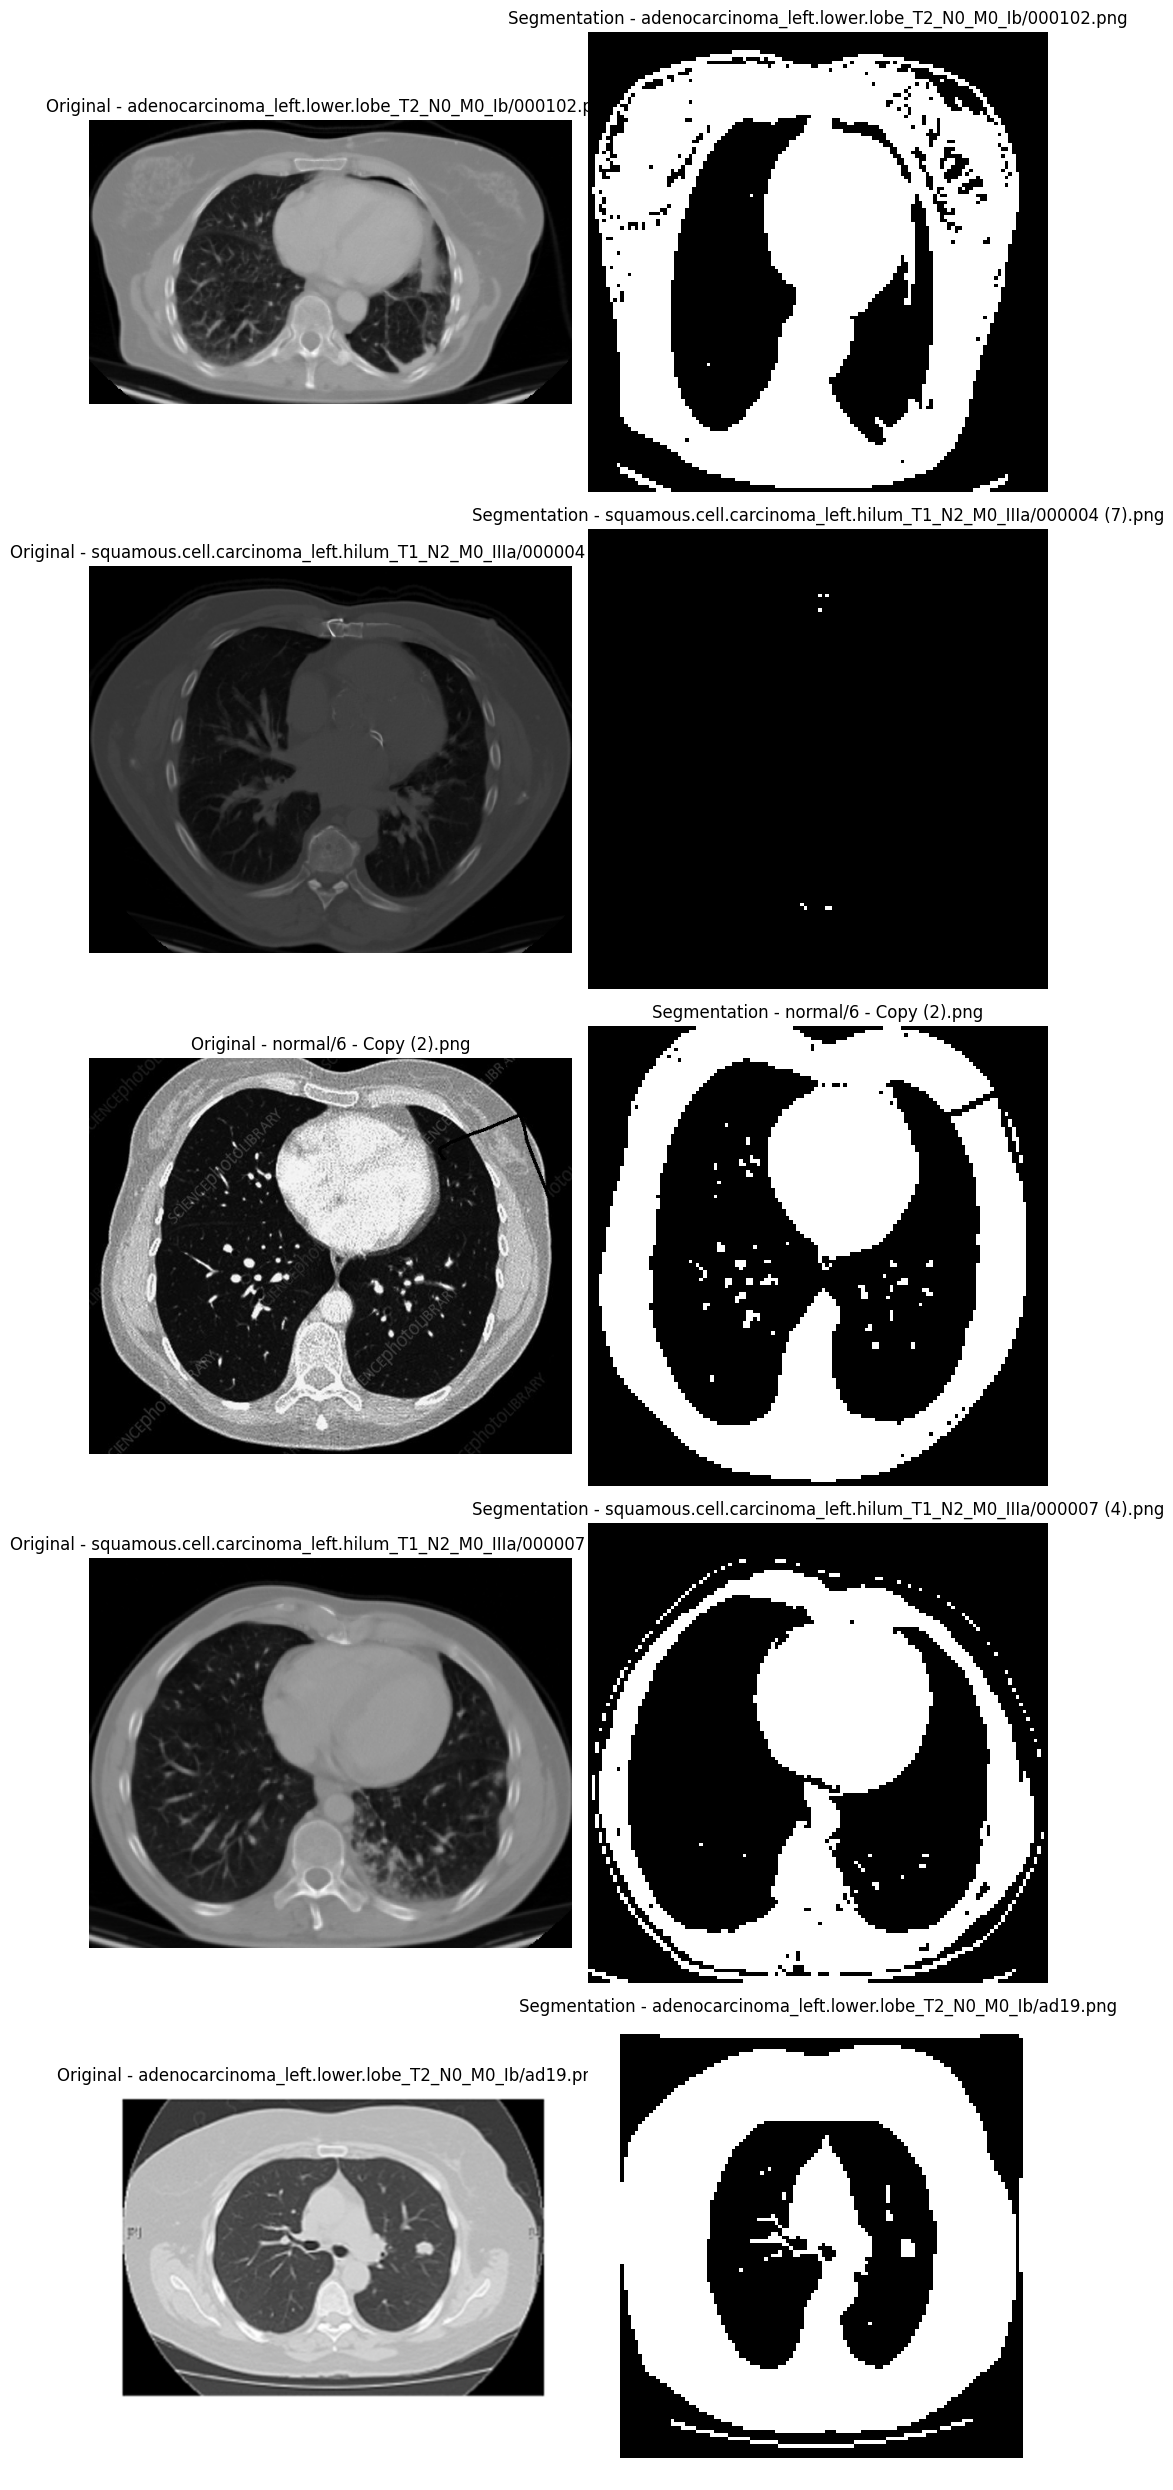

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Paths
original_path = '/content/Data/train'
segmented_path = '/content/CT-scan'

# Number of samples to show
num_samples = 5

# Collect valid (class, image) pairs
samples = []
for class_name in os.listdir(original_path):
    class_orig = os.path.join(original_path, class_name)
    class_seg = os.path.join(segmented_path, class_name)

    if not os.path.isdir(class_orig) or not os.path.isdir(class_seg):
        continue

    images = [f for f in os.listdir(class_orig) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    for img in images:
        if os.path.exists(os.path.join(class_seg, img)):
            samples.append((class_name, img))

# Randomly select samples
selected_samples = random.sample(samples, min(num_samples, len(samples)))

# Plotting
fig, axes = plt.subplots(len(selected_samples), 2, figsize=(10, 5 * len(selected_samples)))

for i, (cls, img_name) in enumerate(selected_samples):
    orig_img = Image.open(os.path.join(original_path, cls, img_name))
    seg_img = Image.open(os.path.join(segmented_path, cls, img_name))

    axes[i, 0].imshow(orig_img)
    axes[i, 0].set_title(f"Original - {cls}/{img_name}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(seg_img, cmap='gray')
    axes[i, 1].set_title(f"Segmentation - {cls}/{img_name}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Dataset Path Definition
# 'CT-scan.zip' was unzipped into a 'Data' folder
# The structure would be: Data/train, Data/test, Data/valid
dataset_path = 'Data'
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')
val_dir = os.path.join(dataset_path, 'valid')

In [ ]:
# Verify paths exist
if not os.path.exists(train_dir):
    print(f"Error: Training directory not found at {train_dir}")
    # To unzipped directly in /content, dataset_path = '/content/CT-scan'
if not os.path.exists(test_dir):
    print(f"Error: Test directory not found at {test_dir}")
if not os.path.exists(val_dir):
    print(f"Error: Validation directory not found at {val_dir}")

In [ ]:
# Data Generators for Loading, Preprocessing, and Augmentation
# train_datagen for training data (with augmentation and rescaling)
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0, 1]
    rotation_range=10,       # Randomly rotate images by up to 10 degrees
    zoom_range=0.1,          # Randomly zoom in/out by up to 10%
    horizontal_flip=True,    # Randomly flip images horizontally
    brightness_range=[0.9, 1.1] # Randomly adjust brightness
)

In [ ]:
# test_val_datagen for validation and test data (only rescaling, no augmentation)
test_val_datagen = ImageDataGenerator(rescale=1./255) # Only normalize pixel values

In [ ]:
# Use .flow_from_directory to load images from specific folders
# train_ds will provide training batches
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical', # For multi-class classification with one-hot encoded labels
    color_mode='rgb',         # Load images as 3-channel RGB (CT scans are grayscale, but VGG19 expects RGB)
    shuffle=True              # Shuffle training data for better generalization
)


Found 613 images belonging to 4 classes.


In [ ]:
# val_ds will provide validation batches
val_ds = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False             # This avoids shuffling of validation data for consistent evaluation
)


Found 72 images belonging to 4 classes.


In [ ]:
# test_ds will provide test batches
test_ds = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False             # This avoids shuffling of  test data for consistent evaluation
)

Found 315 images belonging to 4 classes.


In [ ]:
# Get the class names from the generator (e.g., ['Adenocarcinoma', 'Large cell carcinoma', 'Normal', 'Squamous cell carcinoma'])
class_names = list(train_ds.class_indices.keys())
num_classes = len(class_names)
print(f"\nDetected Classes: {class_names}")
print(f"Number of Classes: {num_classes}")
print(f"Found {train_ds.samples} training images belonging to {train_ds.num_classes} classes.")
print(f"Found {val_ds.samples} validation images belonging to {val_ds.num_classes} classes.")
print(f"Found {test_ds.samples} test images belonging to {test_ds.num_classes} classes.\n")


Detected Classes: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
Number of Classes: 4
Found 613 training images belonging to 4 classes.
Found 72 validation images belonging to 4 classes.
Found 315 test images belonging to 4 classes.



In [ ]:
# Model Architecture Definition (Transfer Learning with VGG19)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Freeze the layers of the base model (VGG19).
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Building the Model
model = Sequential([
    base_model, # Add the pre-trained VGG19 convolutional base
    Flatten(),  # Flatten the output of the convolutional base to feed into dense layers
    # Custom Dense layers for classification:
    # These layers will learn to classify our specific CT-scan conditions
    Dense(units=4096, activation='relu'), # First dense layer with ReLU activation
    Dropout(0.5), # Dropout for regularization to prevent overfitting
    Dense(units=4096, activation='relu'), # Second dense layer with ReLU activation
    Dropout(0.5), # Another dropout layer
    Dense(units=num_classes, activation='softmax') # Output layer: num_classes neurons, softmax for probabilities
])

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Print the model summary to see the architecture, output shapes, and number of parameters
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 4, 4, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    33,558,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │        16,388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,380,612 (268.48 MB)

 Trainable params: 50,356,228 (192.09 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
# Callbacks for Training Control and Optimization ---
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)


In [ ]:
# ModelCheckpoint: This saves the best model weights based on 'val_accuracy'.
# save_best_only=True: Only saves the weights when validation accuracy improves.
model_checkpoint = ModelCheckpoint('best_ct_scan_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)


In [ ]:
# ReduceLROnPlateau: Reduces the learning rate if validation loss plateaus.
# factor=0.5: Reduces learning rate by half. patience=5: After 5 epochs without improvement.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)


In [ ]:
# List of callbacks to use during training
callbacks = [early_stopping, model_checkpoint, reduce_lr]


In [ ]:

# Model Training
# Train the model using the prepared data generators and defined callbacks.
history = model.fit(
    train_ds,            # Training data generator
    epochs=EPOCHS,       # Maximum number of epochs
    validation_data=val_ds, # Validation data generator
    callbacks=callbacks  # List of callbacks to apply
)


--- Starting Model Training ---
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4303 - loss: 1.2326
Epoch 1: val_accuracy improved from -inf to 0.48611, saving model to best_ct_scan_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 180s 9s/step - accuracy: 0.4332 - loss: 1.2260 - val_accuracy: 0.4861 - val_loss: 0.9733 - learning_rate: 0.0010
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5655 - loss: 0.9664
Epoch 2: val_accuracy did not improve from 0.48611
20/20 ━━━━━━━━━━━━━━━━━━━━ 190s 8s/step - accuracy: 0.5649 - loss: 0.9662 - val_accuracy: 0.4861 - val_loss: 0.9919 - learning_rate: 0.0010
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6311 - loss: 0.8262
Epoch 3: val_accuracy improved from 0.48611 to 0.51389, saving model to best_ct_scan_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 177s 9s/step - accuracy: 0.6312 - loss: 0.8262 - val_accuracy: 0.5139 - val_loss: 0.9922 - learning_rate: 0.0010
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5970 - loss: 0.8726
Epoch 4: val_accuracy improved from 0.51389 to 0.52778, saving model to best_ct_scan_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 207s 9s/step - accuracy: 0.5982 - loss: 0.8706 - val_accuracy: 0.5278 - val_loss: 0.8420 - learning_rate: 0.0010
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6599 - loss: 0.8484
Epoch 5: val_accuracy improved from 0.52778 to 0.58333, saving model to best_ct_scan_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 182s 9s/step - accuracy: 0.6597 - loss: 0.8457 - val_accuracy: 0.5833 - val_loss: 0.7994 - learning_rate: 0.0010
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6721 - loss: 0.7074
Epoch 6: val_accuracy did not improve from 0.58333
20/20 ━━━━━━━━━━━━━━━━━━━━ 184s 8s/step - accuracy: 0.6723 - loss: 0.7074 - val_accuracy: 0.5694 - val_loss: 0.8271 - learning_rate: 0.0010
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7383 - loss: 0.6482
Epoch 7: val_accuracy improved from 0.58333 to 0.62500, saving model to best_ct_scan_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 185s 9s/step - accuracy: 0.7375 - loss: 0.6494 - val_accuracy: 0.6250 - val_loss: 0.7403 - learning_rate: 0.0010
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7112 - loss: 0.6395
Epoch 8: val_accuracy did not improve from 0.62500
20/20 ━━━━━━━━━━━━━━━━━━━━ 166s 8s/step - accuracy: 0.7122 - loss: 0.6392 - val_accuracy: 0.5833 - val_loss: 0.7817 - learning_rate: 0.0010
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7564 - loss: 0.6392
Epoch 9: val_accuracy improved from 0.62500 to 0.72222, saving model to best_ct_scan_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 180s 9s/step - accuracy: 0.7565 - loss: 0.6375 - val_accuracy: 0.7222 - val_loss: 0.6879 - learning_rate: 0.0010
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7774 - loss: 0.5469
Epoch 10: val_accuracy did not improve from 0.72222
20/20 ━━━━━━━━━━━━━━━━━━━━ 176s 9s/step - accuracy: 0.7751 - loss: 0.5523 - val_accuracy: 0.5000 - val_loss: 0.8792 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 9.
--- Model Training Complete ---



In [ ]:
# Model Evaluation on Test Set
# Evaluate the final model on the completely unseen test dataset.
# This provides an unbiased measure of the model's real-world performance.
print("\n--- Evaluating Model on Test Set ---")
scores = model.evaluate(test_ds)
print(f"Test Loss: {scores[0]:.4f}")
print(f"Test Accuracy: {scores[1]:.4f}\n")
print("--- Model Evaluation Complete ---\n")


--- Evaluating Model on Test Set ---
10/10 ━━━━━━━━━━━━━━━━━━━━ 69s 7s/step - accuracy: 0.5084 - loss: 1.0435
Test Loss: 1.1218
Test Accuracy: 0.5016

--- Model Evaluation Complete ---



In [ ]:
# Visualize Training History (Accuracy and Loss Plots)
# These plots help diagnose learning issues like overfitting or underfitting.
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

(0.0, 1.0)

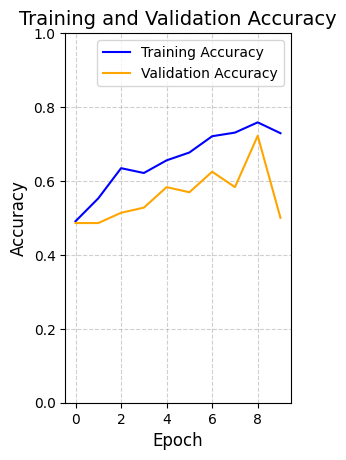

In [ ]:
# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim([0, 1]) # Ensure accuracy scale is 0 to 1


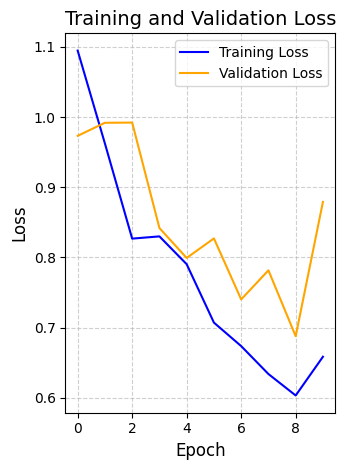

In [ ]:
# Plot Training and Validation Loss
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()


In [ ]:
# Detailed Performance Metrics and Visualizations
# Get predictions for the test set to calculate detailed metrics.
# Use test_ds.reset() to ensure predictions are aligned with true labels. This is important if shuffle=False
test_ds.reset()
Y_pred_probs = model.predict(test_ds) # Get probabilities for each class
Y_pred_classes = np.argmax(Y_pred_probs, axis=1) # Convert probabilities to predicted class indices

# Get true labels from the test generator
Y_true_classes = test_ds.classes

# Classification Report
# Provides Precision, Recall, F1-score, and Support for each class.
print("\n--- Classification Report ---")
print(classification_report(Y_true_classes, Y_pred_classes, target_names=class_names))

10/10 ━━━━━━━━━━━━━━━━━━━━ 70s 7s/step

--- Classification Report ---
                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.58      0.39      0.47       120
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       0.38      0.88      0.53        51
                                          normal       0.55      0.98      0.71        54
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.72      0.14      0.24        90

                                        accuracy                           0.50       315
                                       macro avg       0.56      0.60      0.49       315
                                    weighted avg       0.58      0.50      0.45       315



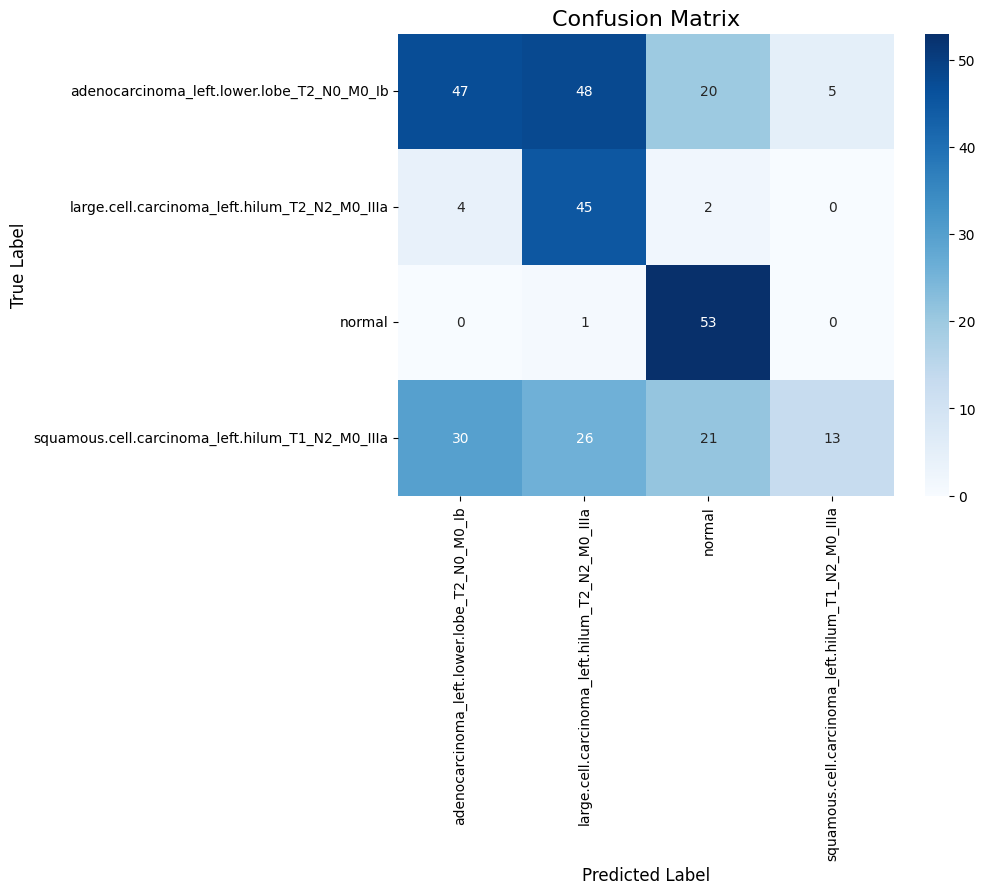

In [ ]:
# Confusion Matrix represented as a Heatmap
# Shows correct vs. incorrect predictions for each class, highlighting misclassifications.
cm = confusion_matrix(Y_true_classes, Y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

In [ ]:
# Multi-Class ROC Curve and AUC
# Binarize the true labels for multi-class ROC calculation
Y_true_binarized = label_binarize(Y_true_classes, classes=np.arange(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_true_binarized[:, i], Y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

<ipython-input-37-3082257689>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes) # Get distinct colors for each class


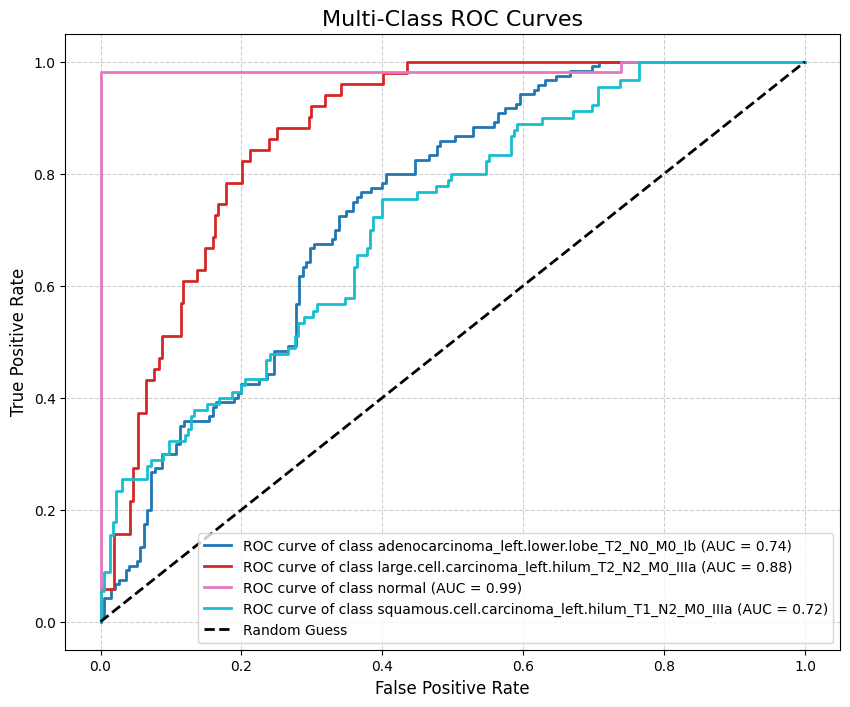

In [ ]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', num_classes) # Get distinct colors for each class
for i, color in zip(range(num_classes), colors.colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess') # Random guess line
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-Class ROC Curves', fontsize=16)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


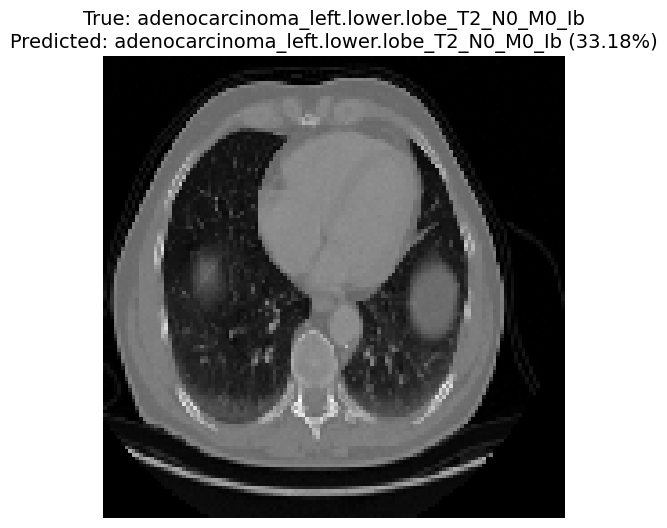

In [ ]:
# Sample Prediction Visualization (Actual Test Image)
# Display a sample image from the test set with its true and predicted labels.
# This provides a qualitative assessment of model performance.

# Take one batch from the test set (if test_ds was reset above, this will be the first batch again)
test_ds.reset()
image_batch, label_batch = next(test_ds) # Get the first batch

# Select a random image from the batch to display
sample_idx = np.random.randint(0, BATCH_SIZE)
sample_image = image_batch[sample_idx]
true_label_one_hot = label_batch[sample_idx]
true_label_idx = np.argmax(true_label_one_hot)
true_label_name = class_names[true_label_idx]

# Get prediction for this specific image from the full batch predictions
sample_prediction_probs = Y_pred_probs[sample_idx] # Use Y_pred_probs calculated earlier
predicted_label_idx = np.argmax(sample_prediction_probs)
predicted_label_name = class_names[predicted_label_idx]
prediction_confidence = sample_prediction_probs[predicted_label_idx] * 100 # Convert to percentage

plt.figure(figsize=(6, 6))
# Ensure image is in displayable format if it was scaled or transformed
display_image = (sample_image * 255).astype(np.uint8) # Convert back to 0-255 for display
plt.imshow(display_image)
plt.title(f"True: {true_label_name}\nPredicted: {predicted_label_name} ({prediction_confidence:.2f}%)", fontsize=14)
plt.axis('off')
plt.show()
